+ Reference : https://github.com/rosinality/glow-pytorch

In [1]:
import torch
from torch import nn, optim
from PIL import Image
from tqdm import tqdm
from torch.nn import functional as F
from math import log, pi, exp
import numpy as np
from scipy import linalg as la
import torchvision.utils as vutils
from torchvision import datasets, transforms, utils
from math import log, sqrt, pi
from torch.autograd import Variable, grad
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
batch_size = 16
iteration = 200000
n_flow = 32
n_block = 4
n_bits = 5
lr = 1e-4
img_size = 64
temp = 0.7
n_sample = 20
data_path = 'data/img_align_celeba'

# Data Load

In [3]:
def sample_data(path, batch_size, image_size):
    transform = transforms.Compose(
        [
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    )

    dataset = datasets.ImageFolder(path, transform=transform)
    loader = DataLoader(dataset, shuffle=True, batch_size=batch_size, num_workers=4)
    loader = iter(loader)
    
    while True:
        try:
            yield next(loader)

        except StopIteration:
            loader = DataLoader(
                dataset, shuffle=True, batch_size=batch_size, num_workers=4
            )
            loader = iter(loader)
            yield next(loader)

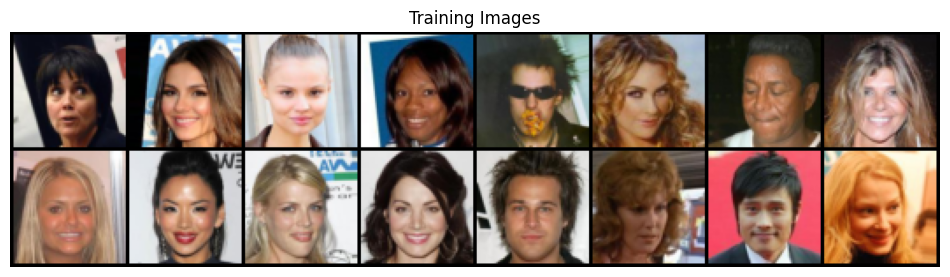

In [4]:
loader = sample_data(data_path, batch_size, img_size)

one_batch = next(iter(loader))
plt.figure(figsize=(12,12))
plt.axis('off')
plt.title('Training Images')
plt.imshow(np.transpose(vutils.make_grid(one_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

# Define Actnorm

In [5]:
def logabs(x):
    return torch.log(torch.abs(x))

In [6]:
class Actnorm(nn.Module):
    def __init__(self, in_channel, logdet=True):
        super().__init__()
        
        # 평균이 0, 표준편차가 1인 것으로 초기화 후 Trainble parameter
        self.loc = nn.Parameter(torch.zeros(1, in_channel, 1, 1))
        self.scale = nn.Parameter(torch.ones(1, in_channel, 1, 1))
        
        self.register_buffer("initialized", torch.tensor(0, dtype=torch.uint8))
        self.logdet = logdet
        
    def initialize(self, input):
        with torch.no_grad():
            flatten = input.permute(1,0,2,3).contiguous().view(input.shape[1], -1)
            mean = (
                flatten.mean(1)
                .unsqueeze(1)
                .unsqueeze(2)
                .unsqueeze(3)
                .permute(1,0,2,3)
            )
            std = (
                flatten.std(1)
                .unsqueeze(1)
                .unsqueeze(2)
                .unsqueeze(3)
                .permute(1,0,2,3)
            )
            
            self.loc.data.copy_(-mean)
            self.scale.data.copy_(1 / (std + 1e-6))
            
    def forward(self, input):
        _, _, height, width = input.shape
        
        if self.initialized.item() == 0:
            self.initialize(input)
            self.initialized.fill_(1)
            
        log_abs = logabs(self.scale)
        
        logdet = height * width * torch.sum(log_abs)
        
        if self.logdet:
            return self.scale + (input + self.loc), logdet
        
        else:
            return self.scale * (input + self.loc)
        
    def reverse(self, output):
        return output / self.scale - self.loc

# Define Invertible 1x1 Conv

In [7]:
class InvCovn2d(nn.Module):
    def __init__(self, in_channel):
        super().__init__()
        
        weight = torch.randn(in_channel, in_channel)
        q, _ = torch.qr(weight)
        weight = q.unsqueeze(2).unsqueeze(3)
        self.weight = nn.Parameter(weight)
        
    def forward(self, input):
        _, _, height, width = input.shape
        
        out = F.conv2d(input, self.weight)
        logdet = ( height * width * torch.slogdet(self.weight.squeeze().double())[1]. float() )
        
        return out, logdet
    
    def reverse(self, output):
        
        return F.conv2d( output, self.weight.squeeze().inverse().unsqueeze(2).unsqueeze(3) )

## LU version

In [8]:
class InvConv2dLU(nn.Module):
    def __init__(self, in_channel):
        super().__init__()
        
        
        weight = np.random.randn(in_channel, in_channel)
        q, _ = la.qr(weight)
        w_p, w_l, w_u = la.lu(q.astype(np.float32)) # w_p : permutation matrix, w_l : lower tri, w_u : upper tir
        w_s = np.diag(w_u) # upper matrix의 대각원소
        w_u = np.triu(w_u, 1) # upper matrix의 상삼각원소만 남긴 행렬
        u_mask = np.triu(np.ones_like(w_u), 1)
        l_mask = u_mask.T
        
        w_p = torch.from_numpy(w_p)
        w_l = torch.from_numpy(w_l)
        w_s = torch.from_numpy(w_s)
        w_u = torch.from_numpy(w_u)
        
        self.register_buffer("w_p", w_p)
        self.register_buffer("u_mask", torch.from_numpy(u_mask))
        self.register_buffer("l_mask", torch.from_numpy(l_mask))
        self.register_buffer("s_sign", torch.sign(w_s))
        self.register_buffer("l_eye", torch.eye(l_mask.shape[0]))
        self.w_l = nn.Parameter(w_l)
        self.w_s = nn.Parameter(logabs(w_s))
        self.w_u = nn.Parameter(w_u)
        
    def forward(self, input):
        _, _, height, width = input.shape
        
        weight = self.calc_weight()
        
        out = F.conv2d(input, weight)
        logdet = height * width * torch.sum(self.w_s)
        
        return out, logdet
    
    def calc_weight(self):
        weight = (
            self.w_p
            @ (self.w_l * self.l_mask + self.l_eye)
            @ ((self.w_u * self.u_mask) + torch.diag(self.s_sign * torch.exp(self.w_s)))
        )
        
        return weight.unsqueeze(2).unsqueeze(3)
    
    def reverse(self, output):
        weight = self.calc_weight()
        
        return F.conv2d(output, weight.squeeze().inverse().unsqueeze(2).unsqueeze(3))

# Define ZeroConv2d

In [9]:
class ZeroConv2d(nn.Module):
    def __init__(self, in_channel, out_channel, padding=1):
        super().__init__()
        
        self.conv = nn.Conv2d(in_channel, out_channel, 3)
        self.conv.weight.data.zero_()
        self.conv.bias.data.zero_()
        self.scale = nn.Parameter(torch.zeros(1, out_channel, 1, 1))
        
    def forward(self, input):
        out = F.pad(input, [1, 1, 1, 1], value=1)
        out = self.conv(out)
        out = out * torch.exp(self.scale * 3)
        
        return out

# Define Affine Coupling Layer

In [10]:
class AffineCoupling(nn.Module):
    def __init__(self, in_channel, filter_size=512, affine=True):
        super().__init__()
        
        self.affine = affine
        
        self.net = nn.Sequential(
            nn.Conv2d(in_channel // 2, filter_size, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(filter_size, filter_size, 1),
            nn.ReLU(inplace=True),
            ZeroConv2d(filter_size, in_channel if self.affine else in_channel // 2),
        )
        
        self.net[0].weight.data.normal_(0, 0.05)
        self.net[0].bias.data.zero_()
        self.net[0].weight.data.normal_(0, 0.05)
        self.net[0].bias.data.zero_()
        
    def forward(self, input):
        in_a, in_b = input.chunk(2, 1) # x_1, x_2 split 작업
        
        if self.affine:
            log_s, t = self.net(in_a).chunk(2,1)
            # s = torch.exp(log_s)
            s = F.sigmoid(log_s + 2)
            # out_a = s * in_a + t
            out_b = (in_b + t) * s
            
            logdet = torch.sum(torch.log(s).view(input.shape[0], -1), 1)
            
        else:
            net_out = self.net(in_a)
            out_b = in_b + net_out
            logdet = None
            
        return torch.cat([in_a, out_b], 1), logdet
    
    def reverse(self, output):
        out_a, out_b = output.chunk(2, 1)
        
        if self.affine:
            log_s, t = self.net(out_a).chunk(2,1)
            # s = torch.exp(log_s)
            s = F.sigmoid(log_s + 2)
            # in_a = (out_a - t) / s
            in_b = out_b / s - t
            
        else:
            net_out = self.net(out_a)
            in_b = out_b - net_out
            
        return torch.cat([out_a, in_b], 1)

# Define Flow

In [11]:
class Flow(nn.Module):
    def __init__(self, in_channel, affine=True, conv_lu=True):
        super().__init__()
        
        self.actnorm = Actnorm(in_channel)
        
        if conv_lu:
            self.invconv = InvConv2dLU(in_channel)
            
        else:
            self.invconv = InvConv2d(in_channel)
            
        self.coupling = AffineCoupling(in_channel, affine=affine)
        
    def forward(self, input):
        out, logdet = self.actnorm(input)
        out, det1 = self.invconv(out)
        out, det2 = self.coupling(out)
        
        logdet = logdet + det1
        if det2 is not None:
            logdet = logdet + det2
            
        return out, logdet
    
    def reverse(self, output):
        input = self.coupling.reverse(output)
        input = self.invconv.reverse(input)
        input = self.actnorm.reverse(input)
        
        return input

# Define posterior distribution

In [12]:
def gaussian_log_p(x, mean, log_sd):
    return -0.5 * log(2 * pi) - log_sd - 0.5 * (x - mean) ** 2 / torch.exp(2 * log_sd)

def gaussian_sample(eps, mean, log_sd):
    return mean + torch.exp(log_sd) * eps

# Define Block

In [13]:
class Block(nn.Module):
    def __init__(self, in_channel, n_flow, split=True, affine=True, conv_lu=True):
        super().__init__()
        
        squeeze_dim = in_channel * 4
        
        self.flows = nn.ModuleList()
        for i in range(n_flow):
            self.flows.append(Flow(squeeze_dim, affine=affine, conv_lu=conv_lu))
            
        self.split = split
        
        if split:
            self.prior = ZeroConv2d(in_channel * 2, in_channel * 4)
        
        else:
            self.prior = ZeroConv2d(in_channel * 4, in_channel * 8)
            
    def forward(self, input):
        b_size, n_channel, height, width = input.shape
        squeezed = input.view(b_size, n_channel, height//2, 2, width//2, 2)
        squeezed = squeezed.permute(0, 1, 3, 5, 2, 4)
        out = squeezed.contiguous().view(b_size, n_channel * 4, height//2, width//2)
        
        logdet = 0
        
        for flow in self.flows:
            out, det = flow(out)
            logdet = logdet + det
            
        if self.split:
            out, z_new = out.chunk(2, 1)
            mean, log_sd = self.prior(out).chunk(2, 1)
            log_p = gaussian_log_p(z_new, mean, log_sd)
            log_p = log_p.view(b_size, -1).sum(1)
            
        else:
            zero = torch.zeros_like(out)
            mean, log_sd = self.prior(zero).chunk(2, 1)
            log_p = gaussian_log_p(out, mean, log_sd)
            log_p = log_p.view(b_size, -1).sum(1)
            z_new = out
            
        return out, logdet, log_p, z_new
    
    def reverse(self, output, eps=None, reconstruct=False):
        input = output
        
        if reconstruct:
            if self.split:
                input = torch.cat([output, eps], 1)
                
            else:
                input = eps
        
        else:
            if self.split:
                mean, log_sd = self.prior(input).chunk(2, 1)
                z = gaussian_sample(eps, mean, log_sd)
                input = torch.cat([output, z], 1 )
                
            else:
                zero = torch.zeros_like(input)
                # zero = F.pad(zero, [1, 1, 1, 1], value=1)
                mean, log_sd = self.prior(zero).chunk(2, 1)
                z = gaussian_sample(eps, mean, log_sd)
                input = z
                
        for flow in self.flows[::-1]:
            input = flow.reverse(input)
            
        b_size, n_channel, height, width = input.shape
        
        unsqueezed = input.view(b_size, n_channel // 4, 2, 2, height, width)
        unsqueezed = unsqueezed.permute(0, 1, 4, 2, 5, 3)
        unsqueezed = unsqueezed.contiguous().view(b_size, n_channel//4, height*2, width*2)
        
        return unsqueezed

# Define Glow

In [14]:
class Glow(nn.Module):
    def __init__(self, in_channel, n_flow, n_block, affine=True, conv_lu=True):
        super().__init__()
        
        self.blocks = nn.ModuleList()
        n_channel = in_channel
        for i in range(n_block - 1):
            self.blocks.append(Block(n_channel, n_flow, affine=affine, conv_lu=conv_lu))
            n_channel *= 2
        self.blocks.append(Block(n_channel, n_flow, split=False, affine=affine))
        
    def forward(self, input):
        log_p_sum = 0
        logdet = 0 
        out = input
        z_outs = []
        
        for block in self.blocks:
            out, det, log_p, z_new = block(out)
            z_outs.append(z_new)
            logdet = logdet + det
            
            if log_p is not None:
                log_p_sum = log_p_sum + log_p
        
        return log_p_sum, logdet, z_outs
    
    def reverse(self, z_list, reconstruct=False):
        for i, block in enumerate(self.blocks[::-1]):
            if i == 0 :
                input = block.reverse(z_list[-1], z_list[-1], reconstruct=reconstruct)
            
            else:
                input = block.reverse(input, z_list[-(i+1)], reconstruct=reconstruct)
                
        return input

# Prepare Train loop

In [15]:
def calc_z_shapes(n_channel, input_size, n_flow, n_block):
    z_shapes = []

    for i in range(n_block - 1):
        input_size //= 2
        n_channel *= 2

        z_shapes.append((n_channel, input_size, input_size))

    input_size //= 2
    z_shapes.append((n_channel * 4, input_size, input_size))

    return z_shapes


def calc_loss(log_p, logdet, image_size, n_bins):
    # log_p = calc_log_p([z_list])
    n_pixel = image_size * image_size * 3

    loss = -log(n_bins) * n_pixel
    loss = loss + logdet + log_p

    return (
        (-loss / (log(2) * n_pixel)).mean(),
        (log_p / (log(2) * n_pixel)).mean(),
        (logdet / (log(2) * n_pixel)).mean(),
    )

# Train Loop

In [16]:
def train(model, optimizer):
    dataset = iter(sample_data(data_path, batch_size, img_size))
    n_bins = 2.0 ** n_bits

    z_sample = []
    z_shapes = calc_z_shapes(3, img_size, n_flow, n_block)
    for z in z_shapes:
        z_new = torch.randn(n_sample, *z) * temp
        z_sample.append(z_new.to(device))

    with tqdm(range(iteration)) as pbar:
        for i in pbar:
            image, _ = next(dataset)
            image = image.to(device)

            image = image * 255

            if n_bits < 8:
                image = torch.floor(image / 2 ** (8 - n_bits))

            image = image / n_bins - 0.5

            if i == 0:
                with torch.no_grad():
                    log_p, logdet, _ = model.module(
                        image + torch.rand_like(image) / n_bins
                    )

                    continue

            else:
                log_p, logdet, _ = model(image + torch.rand_like(image) / n_bins)

            logdet = logdet.mean()

            loss, log_p, log_det = calc_loss(log_p, logdet, img_size, n_bins)
            model.zero_grad()
            loss.backward()
            # warmup_lr = lr * min(1, i * batch_size / (50000 * 10))
            warmup_lr = lr
            optimizer.param_groups[0]["lr"] = warmup_lr
            optimizer.step()

            pbar.set_description(
                f"Loss: {loss.item():.5f}; logP: {log_p.item():.5f}; logdet: {log_det.item():.5f}; lr: {warmup_lr:.7f}"
            )

            if i % 100 == 0:
                with torch.no_grad():
                    utils.save_image(
                        model_single.reverse(z_sample).cpu().data,
                        f"Glow_sample/{str(i + 1).zfill(6)}.png",
                        normalize=True,
                        nrow=10,
                        range=(-0.5, 0.5),
                    )

            if i % 10000 == 0:
                torch.save(
                    model.state_dict(), f"checkpoint/model_{str(i + 1).zfill(6)}.pt"
                )
                torch.save(
                    optimizer.state_dict(), f"checkpoint/optim_{str(i + 1).zfill(6)}.pt"
                )


In [ ]:
if __name__ == "__main__":
    
    logabs: lambda x: torch.log(torch.abs(x))
    
    model_single = Glow(3, n_flow, n_block, affine=True, conv_lu=True)
    model = nn.DataParallel(model_single)
    # model = model_single
    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)

    train(model, optimizer)